# Predizione tempi di percorrenza per sentieri di montagna

L'obiettivo di questo progetto è riuscire a predire il tempo di percorrenza di un sentiero di montagna basandosi su alcune caratteristiche del percorso.

Il [dataset utilizzato](https://www.kaggle.com/roccoli/gpx-hike-tracks) contiene 12141 percorsi registrati come **tracce GPX** ottenute dal sito [hikr.org](https://www.hikr.org/); oltre ai dati GPX (già semplificati per ridurne la dimensione), per ogni istanza sono presenti sia i dati del percorso (distanza, dislivello...) sia della registrazione (utente, data di registrazione...).

**Note**: è chiaro che il tempo di percorrenza dipenda anche da altre caratteristiche difficilmente registrabili o che comunque non siamo in grado di ottenere in questo caso, come il grado di allenamento del camminatore, la dimensione e peso dello zaino, il tipo di scarpe utilizzate (il tipo di suola della scarpa può influire notevolmente sulla velocità di camminata) e altri. Lo scopo del progetto è cercare di ottenere una predizione generale che possa rappresentare l'escursionista medio.

## Descrizione colonne

* **_id**: identificatore unico della traccia
* **user**: il nome dell'utente che ha caricato la traccia
* **name**: titolo assegnato alla traccia dall'autore
* **url**: URL alla pagina di hikr.org relativa alla traccia
* **start_time**: data e ora di inizio della registrazione
* **end_time**: data e ora di fine della registrazione
* **moving_time**: tempo, in secondi, per cui il registratore era in movimento; permette di escludere il tempo dedicato alle soste
* **max_speed**: indica la velocità massima ottenuta durante il percorso
* **length_2d**: lunghezza del percorso in metri senza considerare la variazioni in altitudine; è il valore che si ottiene misurando il percorso su una mappa
* **length_3d**: lunghezza del percorso in metri considerando anche la variazione di altitudine
* **max_elevation**: altitudine massima nell'intero percorso
* **min_elevation**: altitudine minima nell'intero percorso
* **uphill**: dislivello positivo percorso cumulativo, in metri
* **downhill**: dislivello negativo percorso cumulativo, in metri
* **difficulty**: un'indicazione della difficoltà del percorso secondo la [scala SAC](https://www.hikr.org/post17213.html) ([fonte originale](https://www.sac-cas.ch/fileadmin/Ausbildung_und_Wissen/Tourenplanung/Schwierigkeitsskala/Wanderskala-SAC.pdf) in tedesco)
* **bounds**: coordinate GPS dei vertici del rettangolo minimo che racchiude la traccia
* **gpx**: i dati GPX della traccia

Le colonne sicuramente interessanti sono **moving_time**, **length_2d**, **max_elevation**, **min_elevation**, **uphill**, **downhill**, **difficulty**; questi sono dati che possono essere ottenuti facilmente da una mappa o dalla descrizione di un percorso prima di percorrerlo (mentre ad esempio **length_3d** no).

Il campo **bounds** potrebbe essere interessante per individuare la zona del mondo in cui si è svolto il percorso.

## Problemi nei dati

1. **moving_time**: 2349 istanze hanno valore 0: possiamo cercare di recuperare il dato usando la differenza tra **end_time** e **start_time** (ovvero come se non fosse stata fatta nessuna pausa durante il percorso; questo approccio permette di sistemare solamente 6 istanze. Le altre devono essere scartate dato che questo è un dato indispensabile per il risultato che si vuole ottenere. Infine verifichiamo che la velocità media sia sensata, scartando tutte le righe in cui essa è superiore a 15km/h (velocità comunque estremamente difficile da raggiungere).
* **length_2d**: delle istanze rimanenti, 34 hanno valore minore di 1000; è probabile che un percorso tanto breve risulti inutile o fuorviante, quindi si sceglie di scartarle
* Per quanto riguarda le misure di altitudine (**max_elevation**, **min_elevation**, **uphill**, **downhill**), visto che i dati sono molto sporchi, si è scelto di ricalcolarle completamente a partire dalle tracce GPX; in generale i dati di altitudine ottenuti tramite GPS sono [poco affidabili](https://en.wikipedia.org/wiki/Altimeter#Global_Positioning_System), ma a partire dalle coordinate geografiche di ogni punto della traccia è possibile ottenere l'altitudine tramite vari servizi che si basano su mappe precalcolate.  
In questo caso verranno usati i dati della missione [SRTM](https://www2.jpl.nasa.gov/srtm/) della NASA, accessibili e utilizzabili tramite le librerie Python [gpxpy](https://pypi.org/project/gpxpy/) e [srtm.py](https://github.com/tkrajina/srtm.py). Purtroppo il dataset SRTM non ha dati per le latitudini vicine ai poli, quindi alcune tracce (51) devono essere lasciate intoccate. Le tracce per le quali non si riesce a ottenere l'altirudine di tutti i punti vengono eliminate.
* **difficulty** contiene solamente delle stringhe; è necessario convertirlo in un campo categorico ordinato. Oltre ai sei livelli _"ufficiali"_ della scala SAC, nel dataset ogni livello si trova anche variato con un `+` o `-`

Una volta applicate le modifiche precedenti rimangono **9679 istanze**.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
def drop_where(df, condition):
    '''
    Rimuove tutte le righe dal DataFrame `df` per le quali la Series `condition` è `True`.
    Gli indici devono essere compatibili.
    L operazione viene fatta "in place".
    '''
    df.drop(df[condition].index, inplace=True)

def has_all_elevations(gpx):
    ''' Controlla che il gpx abbia i dati di altitudine in tutti i punti '''
    for point in gpx.walk(only_points=True):
        if point.elevation is None:
            return False
    return True

In [3]:
import srtm, srtm.main
import gpxpy
import re
from datetime import timedelta
import os

class LocalSRTMFileHandler(srtm.main.FileHandler):
    def __init__(self, cache_dir):
        self.dir = cache_dir
        if not os.path.isdir(self.dir):
            os.mkdir(self.dir)
        
    def get_srtm_dir(self):
        return self.dir

def clean_data(data):
    # Conversione dei campi temporali
    data['moving_time'] = pd.to_timedelta(data['moving_time'], unit='s')
    time_cols = ['start_time', 'end_time']
    for col in time_cols:
        data[col] = pd.to_datetime(data[col], infer_datetime_format=True, errors='coerce')
    
    # Per i record in cui 'moving_time' è zero,
    # si cerca di calcolarlo come differenza tra 'end_time' e 'start_time'
    no_moving = data['moving_time'] == timedelta(0)
    data.loc[no_moving, 'moving_time'] = data.loc[no_moving, 'end_time'] - data.loc[no_moving, 'start_time']
    
    # Rimozione righe che non hanno un valore di 'moving_time' valido e positivo
    drop_where(data, (data['moving_time'] <= timedelta(0)) | data['moving_time'].isnull())
    
    # Rimozione righe per cui la velocità media è > 15km/h
    hours = data['moving_time'] / timedelta(hours=1)
    km = data['length_2d'] / 1000
    speed = km / hours
    drop_where(data, speed > 15)
    
    # Rimozione righe con 'length_2d' < 1000
    drop_where(data, data['length_2d'] < 1000)
    
    # Ricalcolo altitudine
    gpx_ok = pd.Series(True, index=data.index)
    elevation_data = srtm.get_data(batch_mode=True, file_handler=LocalSRTMFileHandler('srtm_cache'))
    total = len(data)
    for linei, idx in enumerate(data.index):
        print(f'Ricalcolo altitudine {linei+1}/{total}', end='\r')
        try:
            gpx = gpxpy.parse(data.loc[idx, 'gpx'])
        except:
            gpx_ok.loc[idx] = False
        else:
            gpx_ok.loc[idx] = has_all_elevations(gpx)
            retry = True
            while retry:
                retry = False
                try:
                    elevation_data.add_elevations(gpx, smooth=True)
                    gpx.add_missing_elevations()
                except ReadTimeoutError:
                    retry = True
            if has_all_elevations(gpx):
                data.loc[idx, ['min_elevation', 'max_elevation']] = tuple(gpx.get_elevation_extremes())
                data.loc[idx, ['uphill', 'downhill']] = tuple(gpx.get_uphill_downhill())
                data.loc[idx, 'gpx'] = gpx.to_xml()
                gpx_ok.loc[idx] = True
            del gpx
    del elevation_data
    
    print()
    
    # Rimozione righe senza dati di altitudine o con GPX errato
    drop_where(data, ~gpx_ok)
    
    # Difficulty categorica
    order = [
        'T1- - Valley hike',
        'T1 - Valley hike',
        'T1+ - Valley hike',
        'T2- - Mountain hike',
        'T2 - Mountain hike',
        'T2+ - Mountain hike',
        'T3- - Difficult Mountain hike',
        'T3 - Difficult Mountain hike',
        'T3+ - Difficult Mountain hike',
        'T4- - High-level Alpine hike',
        'T4 - High-level Alpine hike',
        'T4+ - High-level Alpine hike',
        'T5- - Challenging High-level Alpine hike',
        'T5 - Challenging High-level Alpine hike',
        'T5+ - Challenging High-level Alpine hike',
        'T6- - Difficult High-level Alpine hike',
        'T6 - Difficult High-level Alpine hike',
        'T6+ - Difficult High-level Alpine hike',
    ]
    data['difficulty'] = pd.Categorical(data['difficulty'], order, ordered=True)
    
    return data

Se necessario il dataset viene scaricato e le trasformazioni descritte sopra vengono applicate. Il risultato viene poi salvato in un file dedicato in formato Pickle.  
**NB**: in questa fase vengono scaricati e salvati i dati SRTM nella cartella locale `srtm_cache`; essa può crescere molto per cui è una buona idea cancellarla dopo averla utilizzata.

In [4]:
import urllib.request
import zipfile
from IPython.display import clear_output
import os

ZIP_FILE = '32068_41607_compressed_gpx-tracks-from-hikr.org.csv.zip'
CSV_FILE = 'gpx-tracks-from-hikr.org.csv'
DATA_FILE = 'tracks.pkl'
URL = 'https://storage.googleapis.com/kaggle-data-sets/32068%2F41607%2Fcompressed%2Fgpx-tracks-from-hikr.org.csv.zip?GoogleAccessId=gcp-kaggle-com@kaggle-161607.iam.gserviceaccount.com&Expires=1593535283&Signature=h9NAiji%2BUfFAwbJk8WrMZSwIWgBL86%2Fbf4qzsIeP95uNP33M8zo4zZIuOvcArZ4lXCkb7Kfn391JhuO1xX2W3iApcn58W0Q1K5d%2FV2XPPEHMP%2B76ovsbSescESqrHktXsO%2BA1KtILyM1B4eE%2BEDBpRSoAyXvUmdsQAjGp82U3LvE8JJgOaeSqFN6rSmMkHYEMguhlPoQXcpnNFNh7y0shk85tUhx%2BIbQoPAqtmCF0%2FiazOROZCT%2BpdM8eSMBt%2F1OzMD4k9%2F40ripEW1Y2y5DKKj2%2FwCvUULWNoCO1NJWV8eN1C4lefbHRyOm4VtmOaDjeaAVOAlsCQoLLst9%2B443DA%3D%3D'

def update_progress(blocks, block_size, total_size):
    bar_len = 20 # Characters
    percent = (blocks * block_size) / total_size
    progress = int(percent * bar_len)
    text = 'Downloading file [{0}] {1:.1f}%'.format('#' * progress + '-' * (bar_len - progress), percent*100)
    clear_output(wait=True)
    print(text)


if not os.path.exists(DATA_FILE):
    if not os.path.exists(CSV_FILE):
        if not os.path.exists(ZIP_FILE):
            urllib.request.urlretrieve(URL, ZIP_FILE, update_progress)
        print('Extracting file')
        with zipfile.ZipFile(ZIP_FILE, 'r') as zip_ref:
            zip_ref.extractall('.')
    raw_data = pd.read_csv(CSV_FILE)
    data = clean_data(raw_data)
    data.to_pickle(DATA_FILE)
    del data
    del raw_data
    print("Done")

In [5]:
data = pd.read_pickle(DATA_FILE)

In [6]:
useful_fields = ['moving_time', 'length_2d', 'max_elevation', 'min_elevation', 'uphill', 'downhill', 'difficulty']

## Analisi dei dati
A giudicare dai grafici, in particolare i _Box Plot_ , si può notare l'elevata presenza di outliers; in questo caso però i dati sono verosimili ed è improbabile che derivino da errori di qualsiasi tipo: sono semplicemente percorsi "estremi" che vengono effettuati molto di rado perchè estremamente impegnativi. Si è scelto dunque di mantenerli dato che contengono comunque informazioni utili.

,downhill,uphill,length_2d,max_elevation,min_elevation,moving_minutes
count,9679.000000,9679.000000,9679.000000,9679.000000,9679.000000,9679.000000
mean,976.670231,1034.208396,14326.546052,1925.192095,1027.342256,267.889684
std,736.931095,715.459755,11129.926875,755.533204,569.018297,180.225887
min,0.000000,0.000000,1002.181911,2.000000,-91.000000,12.983333
25%,554.260456,638.251488,9075.881552,1400.000000,584.000000,174.641667
50%,930.098490,977.020195,12575.356514,1967.333333,974.000000,251.416667
75%,1319.202070,1333.992000,17036.020433,2461.074052,1399.658499,331.300000
max,26565.667000,29286.167000,226907.816848,5604.216189,4191.000000,3156.333333


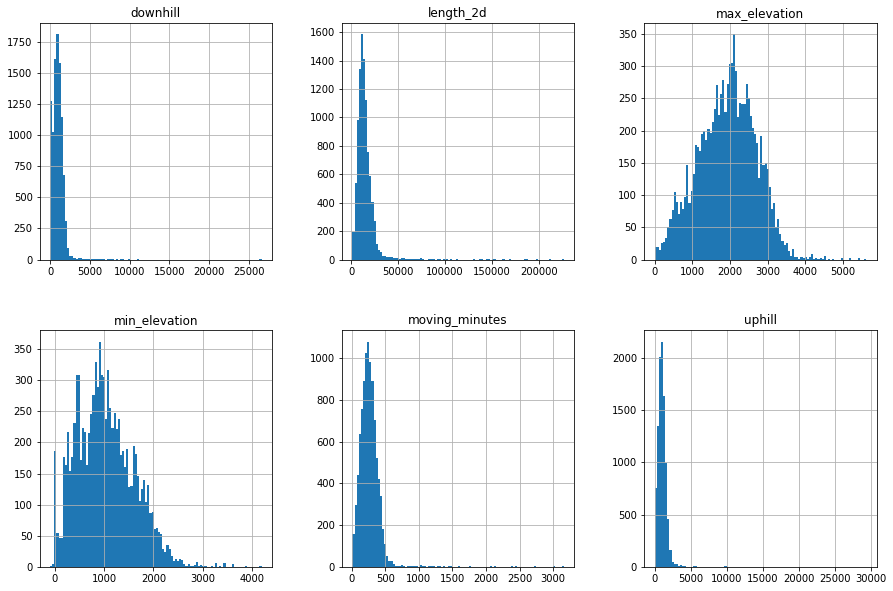

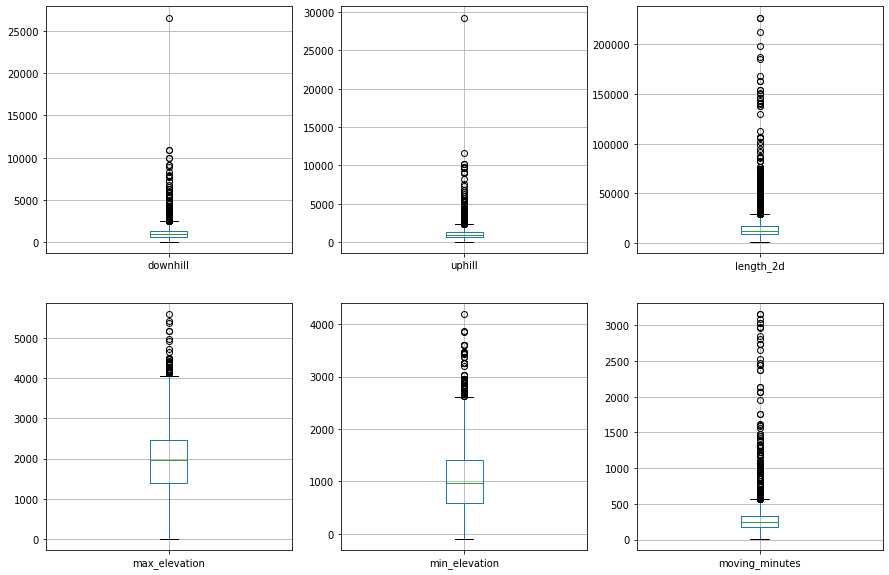

In [7]:
cols = ['downhill', 'uphill', 'length_2d', 'max_elevation', 'min_elevation', 'moving_minutes']
data['moving_minutes'] = data['moving_time'].dt.total_seconds() / 60

# Descrizione dei dati
display(data[cols].describe())

# Istogrammi
data[cols].hist(bins=100, figsize=(15,10), layout=(2, 3));

# Box plots
fig, axes = plt.subplots(2, 3, figsize=(15,10))
for ax, col in zip(axes.flat, cols):
    data[[col]].boxplot(ax=ax);

## Correlazioni tra i dati

### `uphill` / `downhill`
C'è una correlazione lineare tra queste due variabili, specialmente per valori più alti; per valori più bassi è più debole, ma comunque presente. Questo è dovuto probabilmente al fatto che molte volte si percorre un sentiero ad anello.

Indice di correlazione tra tutti i valori:		0.8709789632375514
Indice di correlazione tra i valori minori di 2000:	0.7535933523097729


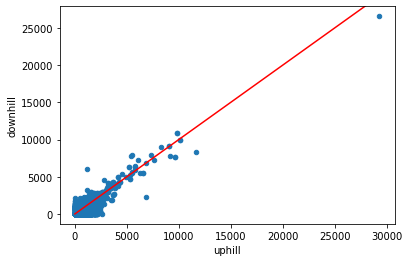

In [8]:
ax = data.plot.scatter('uphill', 'downhill')
ax.plot([0,30000], [0, 30000], scalex=False, scaley=False, c='red');
corr_all = np.corrcoef(data['uphill'], data['downhill'])[0,1]
small = data[(data['uphill'] <= 2000) & (data['downhill'] <= 2000)]
corr_small = np.corrcoef(small['uphill'], small['downhill'])[0,1]

print(f'Indice di correlazione tra tutti i valori:\t\t{corr_all}')
print(f'Indice di correlazione tra i valori minori di 2000:\t{corr_small}')

### `min_elevation` / `max_elevation`
Anche tra queste due variabili è presente un certo grado di correlazione lineare; ovviamente l'altitudine massima sarà sempre maggiore della minima. Dal primo grafico si può vedere che i dati sono distribuiti in modo abbastanza simmetrico attorno alla diagonale traslata verso l'alto di 1000; il secondo grafico mostra che la differenza tra altitudine massima e minima può essere approssimata con una gaussiana centrata in 1000 (prevedibile dai grafici della sezione precedente, in cui `min_elevation` e `max_elevation` hanno una distribuzione simile alla gaussiana, la prima centrata in 1000 e la seconda centrata in 2000).

Indice di correlazione:	0.7984723804600158


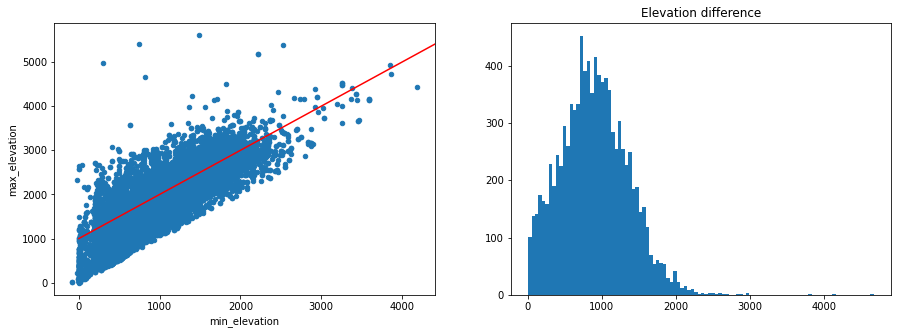

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
data.plot.scatter('min_elevation', 'max_elevation', ax=axes[0])
axes[0].plot([0,20000], [1000, 21000], scalex=False, scaley=False, c='red');
corr_all = np.corrcoef(data['min_elevation'], data['max_elevation'])[0,1]

elevation_diff = data['max_elevation'] - data['min_elevation']
axes[1].hist(elevation_diff, bins=100);
axes[1].set_title("Elevation difference")

print(f'Indice di correlazione:\t{corr_all}')

### Correlazioni con `moving_time`
Dai grafici si può notare che esiste una correlazione, seppur non forte, tra alcune variabili e il tempo in movimento. In particolare si può notare che `length_2d` è l'attributo con maggiore correlazione, mentre con `max_elevation`, `min_elevation` e `difficulty` sembra non esserci alcuna correlazione.

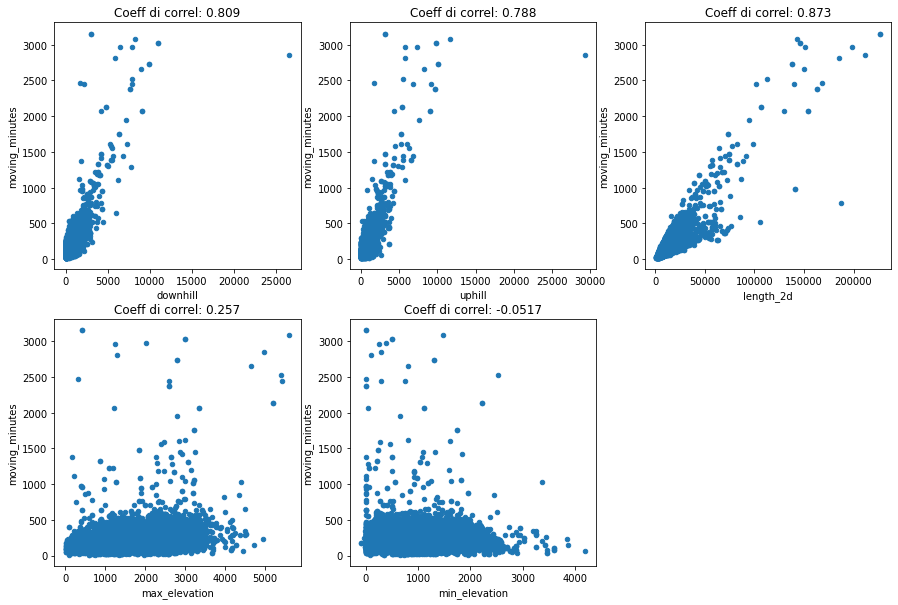

In [10]:
fig, axes = plt.subplots(2,3, figsize=(15,10))
cols = ['downhill', 'uphill', 'length_2d', 'max_elevation', 'min_elevation']
for col, ax in zip(cols, axes.flat):
    correlation = np.corrcoef(data[col], data['moving_minutes'])[0,1]
    data.plot.scatter(col, 'moving_minutes', ax=ax, title=f"Coeff di correl: {correlation:.3}")
axes.flat[-1].axis('off');

## Normalizzazione / standardizzazione

Per prima cosa è importante convertire l'attributo `difficulty`, che è di tipo _ordinale_ , in valori numerici: leggendo le descrizioni dei diversi livelli della scala forniti da SAC è però possibile dedurre che la difficoltà aumenta in modo quadratico con il livello. In questo modo sarà possibile dare un significato **quantitativo** alla difficoltà di un percorso.

In [11]:
data['difficulty'] = data['difficulty'].factorize(sort=True)[0]**2

I valori delle feature vengono normalizzati per portarli tutti nello stesso dominio. Considerando lo scarto interquartile per determinare un'approssimazione del dominio, si nota che le diverse variabili hanno intervalli anche molto diversi.

In [12]:
cols = ['downhill', 'uphill', 'length_2d', 'max_elevation', 'min_elevation', 'difficulty', 'moving_minutes']
stats = data[cols].describe()
pd.DataFrame((stats.loc['75%'] - stats.loc['25%']), columns=['Scarto interquartile'])

,Scarto interquartile
downhill,764.941614
uphill,695.740512
length_2d,7960.138881
max_elevation,1061.074052
min_elevation,815.658499
difficulty,15.000000
moving_minutes,156.658333


Per affettuare le standardizzazione possiamo usare la classe `StandardScaler` offerta da `scikit-learn`

In [13]:
scaler = StandardScaler()
scaled_data = data.copy()
scaled_data[cols] = scaler.fit_transform(data[cols])
scaled_data[cols].describe()
stats = scaled_data[cols].describe()
pd.DataFrame((stats.loc['75%'] - stats.loc['25%']), columns=['Scarto interquartile'])

,Scarto interquartile
downhill,1.038063
uphill,0.972489
length_2d,0.715238
max_elevation,1.404477
min_elevation,1.433523
difficulty,0.609267
moving_minutes,0.869278


Si può vedere che ora lo scarto interquartile è intorno a 1 per tutte le features.


* **difficulty**: è una stringa che descrive il livello di difficoltà; può essere facilmente interpretata per estrarne il livello (da 1 a 6) con variazione (`+` o `-`), anche se nella scala ufficiale non viene indicato è presente nel dataset. Possiamo dire che questa scala è un dato di tipo _ordinale_ : leggendo le descrizioni è però possibile dedurre che la difficoltà aumenta in modo quadratico con il livello.

In [14]:
    
#     # Conversione difficoltà; il modificatore '+' o '-' viene gestito aggiungendo o togliendo 1/3 al livello
#     # corrispondente (ad esempio '4+' diventa 4.333, mentre '4-' diventa 3.666) per ottenere una scala
#     # equispaziata. I valori così ottenuti vengono elevati al quadrato per ottenere una scala quadratica.
#     print('Conversione difficoltà')
#     parsed = data['difficulty'].str.extract('^T(\d)([+-])?.*$')
#     parsed[1].replace({'+': 1, '-': -1, np.nan: 0}, inplace=True)
#     parsed[1] *= 1/3
#     data['difficulty'] = (parsed[0].astype(int) + parsed[1])**2

#### Modelli
* Regressione lineare 
* Polinomiale
* Funzioni kernel
* Gaussian Radial Basis Function

#### Usando
* LASSO (confrontare con modelli che non la usano)
* Grid-search 
* Random-search (?)

#### Indici
* $R^2$
* F1-Measure
* Intervalli di confidenza al 95%